<a href="https://colab.research.google.com/github/AmyHumke12/SolarProject/blob/main/IPTV_SolarProduction_Split_Pre_Processing_Step_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 3 of preprocessing (optional do either this or Part 4)
This notebook will apply preprocessing that needs to be done post split. It will also examine base models that can be compared against later models that use transformed features.

At this point, I will also drop the weather variables as they will not be available for the future data

This notebook can be skipped in the workflow, its purpose is to derive a base model comparison to judge performance in the next notebook.

In [ ]:
pip install xgboost

In [ ]:
#Requirements
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import pickle
from itertools import combinations
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor



# Ensure inline plotting in Jupyter notebooks or Google Colab
%matplotlib inline


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load Data

In [ ]:
# Specify the file paths where the pickle files are saved
train_df_path = '/content/drive/My Drive/train_df.pkl'
test_df_path = '/content/drive/My Drive/test_df.pkl'

# Load the DataFrames from the pickle files
train_df = pd.read_pickle(train_df_path)
print("train_df has been loaded successfully.")

test_df = pd.read_pickle(test_df_path)
print("test_df has been loaded successfully.")


train_df has been loaded successfully.
test_df has been loaded successfully.


In [ ]:
train_df

,date,month,day_of_month,hour,is_daylight,solar_angle,solar_azimuth,temperature_2m,relative_humidity_2m,dew_point_2m,...,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_gusts_10m,sunshine_duration,global_tilted_irradiance,value,solar_day_count,Estimated_Area_Solar_Production
0,2024-01-09 07:00:00,1,9,7,1,-4.132298,116.331676,26.209400,87.365189,22.969400,...,100.0,84.0,100.0,2.530877,5.145100,0.000000,0.000000,1.000000e-10,19,0.494
1,2024-01-09 08:00:00,1,9,8,1,5.410634,126.501911,27.019400,86.426872,23.509399,...,100.0,16.0,100.0,3.641572,6.934700,0.000000,8.517692,1.000000e-10,19,2.773
2,2024-01-09 09:00:00,1,9,9,1,13.549794,137.851109,30.079399,82.816345,25.489399,...,100.0,13.0,100.0,5.854789,12.303500,0.000000,58.677433,2.300000e-02,19,4.560
3,2024-01-09 10:00:00,1,9,10,1,20.018658,150.681468,32.329399,82.365807,27.559401,...,82.0,1.0,100.0,8.456333,17.224899,0.000000,113.569221,1.560000e-01,19,5.780
4,2024-01-09 11:00:00,1,9,11,1,24.211071,164.975777,33.589401,72.969177,25.849400,...,96.0,47.0,100.0,10.106191,21.027800,3600.000000,193.026047,2.400000e-01,19,6.316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932,2024-06-07 16:00:00,6,7,16,1,46.450310,258.795216,71.119400,39.706631,45.379402,...,1.0,59.0,0.0,15.607785,36.015701,3600.000000,390.958862,3.453000e+00,169,3.063
1933,2024-06-07 17:00:00,6,7,17,1,35.432409,269.873402,70.579399,41.843700,46.279400,...,0.0,13.0,0.0,14.005835,31.094299,3600.000000,455.640259,2.643000e+00,169,1.215
1934,2024-06-07 18:00:00,6,7,18,1,24.403081,279.478910,69.049400,45.763466,47.269402,...,0.0,10.0,0.0,11.608715,27.291399,3600.000000,343.391602,1.561000e+00,169,0.365
1935,2024-06-07 19:00:00,6,7,19,1,13.684789,288.674319,67.159401,50.684635,48.259399,...,0.0,88.0,0.0,9.906147,21.027800,3291.995605,197.221893,4.820000e-01,169,0.344


In [ ]:
train_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1937 entries, 0 to 1936
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             1937 non-null   datetime64[ns]
 1   month                            1937 non-null   int32         
 2   day_of_month                     1937 non-null   int32         
 3   hour                             1937 non-null   int32         
 4   is_daylight                      1937 non-null   int64         
 5   solar_angle                      1937 non-null   float64       
 6   solar_azimuth                    1937 non-null   float64       
 7   temperature_2m                   1937 non-null   float32       
 8   relative_humidity_2m             1937 non-null   float32       
 9   dew_point_2m                     1937 non-null   float32       
 10  precipitation                    1937 non-null   float32       
 

#Drop the weather fields from the analysis.

In [ ]:
# List of fields to drop
fields_to_drop = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'precipitation',
    'snow_depth', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid',
    'cloud_cover_high', 'wind_speed_10m', 'wind_gusts_10m', 'sunshine_duration'
]

# Drop the fields from train_df and test_df
train_df = train_df.drop(columns=fields_to_drop, errors='ignore')
test_df = test_df.drop(columns=fields_to_drop, errors='ignore')

# Confirm the fields have been removed
print("Updated train_df columns:")
print(train_df.columns)

print("\nUpdated test_df columns:")
print(test_df.columns)


Updated train_df columns:
Index(['date', 'month', 'day_of_month', 'hour', 'is_daylight', 'solar_angle',
       'solar_azimuth', 'global_tilted_irradiance', 'value', 'solar_day_count',
       'Estimated_Area_Solar_Production'],
      dtype='object')

Updated test_df columns:
Index(['date', 'month', 'day_of_month', 'hour', 'is_daylight', 'solar_angle',
       'solar_azimuth', 'global_tilted_irradiance', 'value', 'solar_day_count',
       'Estimated_Area_Solar_Production'],
      dtype='object')


#Feature Engineering

##Explore modifying the Estimated Area Solar Production to tailor it more exactly to the real production value

In [ ]:
train_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1937 entries, 0 to 1936
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             1937 non-null   datetime64[ns]
 1   month                            1937 non-null   int32         
 2   day_of_month                     1937 non-null   int32         
 3   hour                             1937 non-null   int32         
 4   is_daylight                      1937 non-null   int64         
 5   solar_angle                      1937 non-null   float64       
 6   solar_azimuth                    1937 non-null   float64       
 7   global_tilted_irradiance         1937 non-null   float32       
 8   value                            1937 non-null   float64       
 9   solar_day_count                  1937 non-null   int64         
 10  Estimated_Area_Solar_Production  1937 non-null   float64       
d

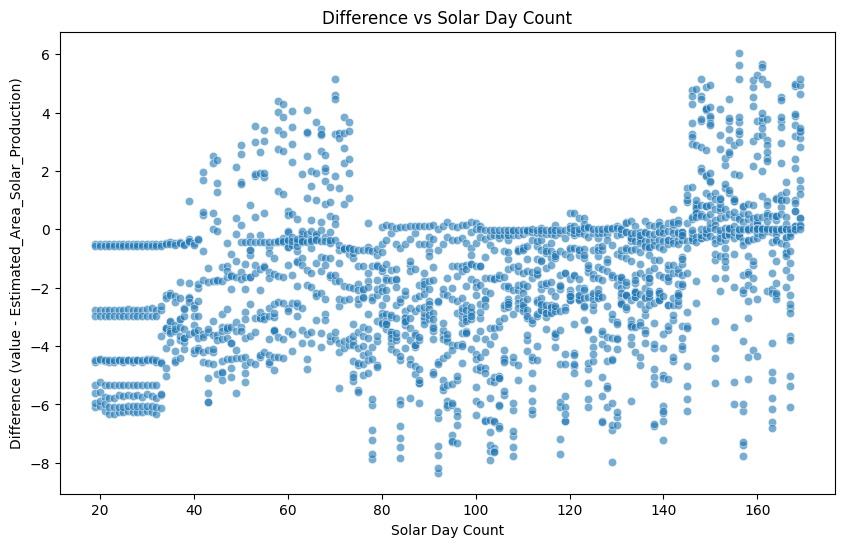

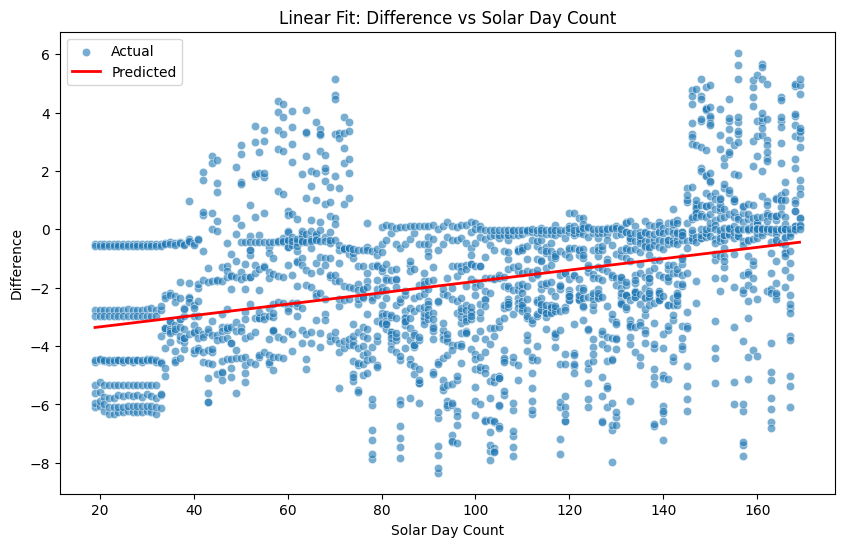

R² of the linear regression: 0.107


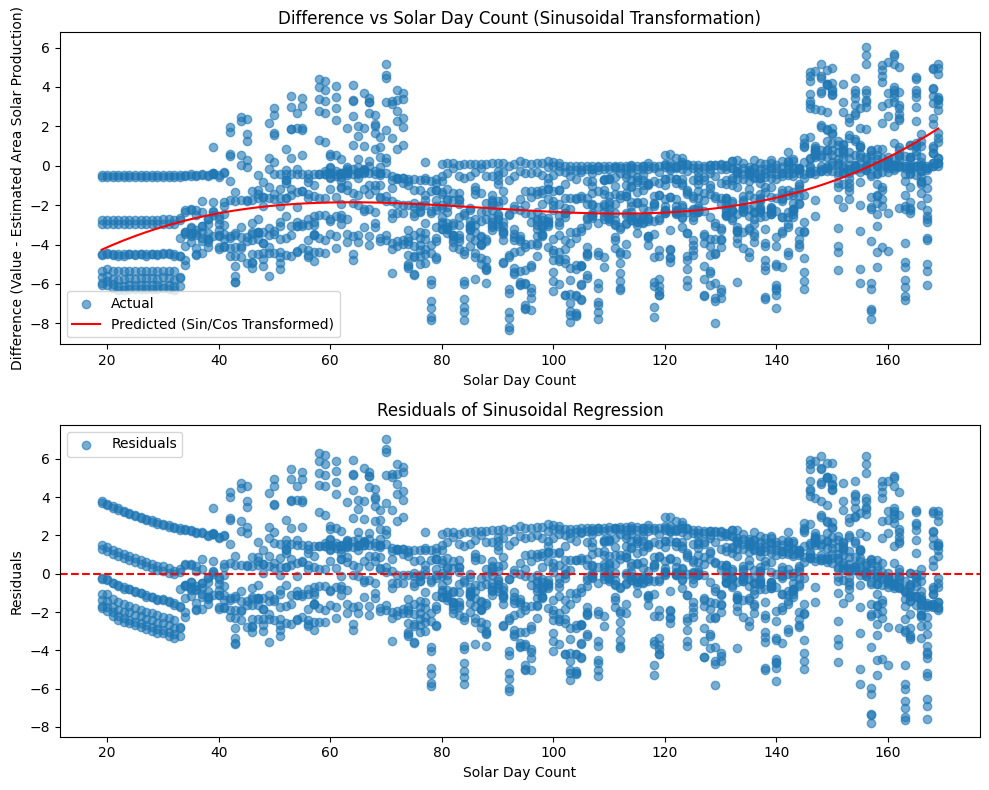

R² of the sinusoidal transformation regression: 0.199
          value  Estimated_Area_Solar_Production  corrected_estimate
0  1.000000e-10                            0.494            -3.77012
1  1.000000e-10                            2.773            -1.49112
2  2.300000e-02                            4.560             0.29588
3  1.560000e-01                            5.780             1.51588
4  2.400000e-01                            6.316             2.05188
      Estimated_Area_Solar_Production  corrected_estimate
1953                            0.149             2.41905
1954                            1.502             3.77205
1955                            3.674             5.94405
1956                            5.494             7.76405
1957                            6.983             9.25305


In [ ]:
# Step 1.1: Calculate the difference in the training set
train_df['difference'] = train_df['value'] - train_df['Estimated_Area_Solar_Production']

# Step 1.2: Plot the difference vs. solar_day_count
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df['solar_day_count'], y=train_df['difference'], alpha=0.6)
plt.title("Difference vs Solar Day Count")
plt.xlabel("Solar Day Count")
plt.ylabel("Difference (value - Estimated_Area_Solar_Production)")
plt.show()

# Step 1.3: Fit a linear regression model to assess the relationship
solar_day_count = train_df[['solar_day_count']].values.reshape(-1, 1)
difference = train_df['difference'].values.reshape(-1, 1)

linear_model = LinearRegression()
linear_model.fit(solar_day_count, difference)

# Predict the difference using the regression model
predicted_difference = linear_model.predict(solar_day_count)

# Plot regression fit
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df['solar_day_count'], y=train_df['difference'], alpha=0.6, label="Actual")
plt.plot(train_df['solar_day_count'], predicted_difference, color="red", label="Predicted", linewidth=2)
plt.title("Linear Fit: Difference vs Solar Day Count")
plt.xlabel("Solar Day Count")
plt.ylabel("Difference")
plt.legend()
plt.show()

# Step 1.4: Assess the goodness of fit
r2 = r2_score(difference, predicted_difference)
print(f"R² of the linear regression: {r2:.3f}")

# Step 2.1: Apply a sinusoidal transformation (adjusted for hourly data)
train_df['sin_transformed'] = np.sin(2 * np.pi * train_df['solar_day_count'] / 8766)
train_df['cos_transformed'] = np.cos(2 * np.pi * train_df['solar_day_count'] / 8766)

# Prepare the transformed features for regression
X_transformed = train_df[['solar_day_count', 'sin_transformed', 'cos_transformed']]
y_difference = train_df['value'] - train_df['Estimated_Area_Solar_Production']

# Fit a linear regression model
regressor = LinearRegression()
regressor.fit(X_transformed, y_difference)

# Predict differences using the sinusoidal features
y_pred_transformed = regressor.predict(X_transformed)

# Calculate the R² value
r2_transformed = r2_score(y_difference, y_pred_transformed)

# Plot the actual vs predicted differences
plt.figure(figsize=(10, 8))

# Scatter plot of actual differences
plt.subplot(2, 1, 1)
plt.scatter(train_df['solar_day_count'], y_difference, alpha=0.6, label="Actual")
plt.plot(train_df['solar_day_count'], y_pred_transformed, color='red', label="Predicted (Sin/Cos Transformed)")
plt.xlabel("Solar Day Count")
plt.ylabel("Difference (Value - Estimated Area Solar Production)")
plt.title("Difference vs Solar Day Count (Sinusoidal Transformation)")
plt.legend()

# Residuals plot
plt.subplot(2, 1, 2)
plt.scatter(train_df['solar_day_count'], y_difference - y_pred_transformed, alpha=0.6, label="Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Solar Day Count")
plt.ylabel("Residuals")
plt.title("Residuals of Sinusoidal Regression")
plt.legend()

plt.tight_layout()
plt.show()

# Print the R² value
print(f"R² of the sinusoidal transformation regression: {r2_transformed:.3f}")

# Step 3: Drop unnecessary columns from train_df and test_df
columns_to_drop = ['difference', 'month_day', 'month_day_encoded']
train_df = train_df.drop(columns=columns_to_drop, errors='ignore')
test_df = test_df.drop(columns=columns_to_drop, errors='ignore')

# Apply the sinusoidal transformation to train_df and test_df
train_df['sin_transformed'] = np.sin(2 * np.pi * train_df['solar_day_count'] / 8766)
train_df['cos_transformed'] = np.cos(2 * np.pi * train_df['solar_day_count'] / 8766)

test_df['sin_transformed'] = np.sin(2 * np.pi * test_df['solar_day_count'] / 8766)
test_df['cos_transformed'] = np.cos(2 * np.pi * test_df['solar_day_count'] / 8766)

# Use the trained regression model to predict the differences
train_features = train_df[['solar_day_count', 'sin_transformed', 'cos_transformed']]
test_features = test_df[['solar_day_count', 'sin_transformed', 'cos_transformed']]

# Predict the differences for train and test sets
train_df['predicted_difference'] = regressor.predict(train_features)
test_df['predicted_difference'] = regressor.predict(test_features)

# Compute the corrected estimate
train_df['corrected_estimate'] = train_df['Estimated_Area_Solar_Production'] + train_df['predicted_difference']
test_df['corrected_estimate'] = test_df['Estimated_Area_Solar_Production'] + test_df['predicted_difference']

# Drop temporary columns if necessary
columns_to_cleanup = ['sin_transformed', 'cos_transformed', 'predicted_difference']
train_df = train_df.drop(columns=columns_to_cleanup, errors='ignore')
test_df = test_df.drop(columns=columns_to_cleanup, errors='ignore')

# Verify the new corrected_estimate
print(train_df[['value', 'Estimated_Area_Solar_Production', 'corrected_estimate']].head())
print(test_df[['Estimated_Area_Solar_Production', 'corrected_estimate']].head())


#Initial Models prior to data transformations

In [ ]:
# For train_df
train_X = train_df  # Features
train_y = train_df['value']  # Target

# For test_df
test_X = test_df  # Features
test_y = test_df['value']  # Target

# Optional: Display shapes to verify
print(f"train_X shape: {train_X.shape}, train_y shape: {train_y.shape}")
print(f"test_X shape: {test_X.shape}, test_y shape: {test_y.shape}")


train_X shape: (1937, 12), train_y shape: (1937,)
test_X shape: (1404, 12), test_y shape: (1404,)


##What value to optimize?
- Research is suggesting cnMAE (capacity normalized mean square error) is a good optmization.  This uses nMAE with an additional normalization step for capacity.
- https://web.archive.org/web/20240914174057/https://www.renewableenergyworld.com/solar/solar-forecasting-needs-a-better-accuracy-metric/#gref
- Author: Sean Kelly Renewable Energy World 9/4/2024
- Target Value 15% or less
- Hourly capacity of my system is rated at 15.2 but 12.2 is the highest hourly production it has ever had. The last notebook computed the Daily_Capacity to be 12.3*total_daily_daylight_hours

In [ ]:
# Set 'date' as the index and drop it from the features
train_X = train_df.set_index('date').drop(columns=['value'])  # Features DataFrame with 'date' as index
train_y = train_df['value']  # Target as a Series

test_X = test_df.set_index('date').drop(columns=['value'])  # Features DataFrame with 'date' as index
test_y = test_df['value']  # Target as a Series


##Pickle train_X, train_y, test_X, and test_y.

In [ ]:
# Specify the file paths where you want to save the pickle files
train_X_path = '/content/drive/My Drive/train_X.pkl'
train_y_path = '/content/drive/My Drive/train_y.pkl'
test_X_path = '/content/drive/My Drive/test_X.pkl'
test_y_path = '/content/drive/My Drive/test_y.pkl'

# Save the DataFrames and Series as pickle files
train_X.to_pickle(train_X_path)
print(f"train_X has been saved to {train_X_path}")

train_y.to_pickle(train_y_path)
print(f"train_y has been saved to {train_y_path}")

test_X.to_pickle(test_X_path)
print(f"test_X has been saved to {test_X_path}")

test_y.to_pickle(test_y_path)
print(f"test_y has been saved to {test_y_path}")


train_X has been saved to /content/drive/My Drive/train_X.pkl
train_y has been saved to /content/drive/My Drive/train_y.pkl
test_X has been saved to /content/drive/My Drive/test_X.pkl
test_y has been saved to /content/drive/My Drive/test_y.pkl


In [ ]:
train_X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1937 entries, 2024-01-09 07:00:00 to 2024-06-07 20:00:00
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   month                            1937 non-null   int32  
 1   day_of_month                     1937 non-null   int32  
 2   hour                             1937 non-null   int32  
 3   is_daylight                      1937 non-null   int64  
 4   solar_angle                      1937 non-null   float64
 5   solar_azimuth                    1937 non-null   float64
 6   global_tilted_irradiance         1937 non-null   float32
 7   solar_day_count                  1937 non-null   int64  
 8   Estimated_Area_Solar_Production  1937 non-null   float64
 9   corrected_estimate               1937 non-null   float64
dtypes: float32(1), float64(4), int32(3), int64(2)
memory usage: 136.2 KB


##Load Pickle.

In [ ]:
# Specify the file paths where the pickle files are saved
train_X_path = '/content/drive/My Drive/train_X.pkl'
train_y_path = '/content/drive/My Drive/train_y.pkl'
test_X_path = '/content/drive/My Drive/test_X.pkl'
test_y_path = '/content/drive/My Drive/test_y.pkl'

# Load the DataFrames and Series from pickle files
train_X = pd.read_pickle(train_X_path)
print(f"train_X has been loaded from {train_X_path}")

train_y = pd.read_pickle(train_y_path)
print(f"train_y has been loaded from {train_y_path}")

test_X = pd.read_pickle(test_X_path)
print(f"test_X has been loaded from {test_X_path}")

test_y = pd.read_pickle(test_y_path)
print(f"test_y has been loaded from {test_y_path}")

# Verify the loaded data
print("train_X:")
print(train_X.head())

print("\ntrain_y:")
print(train_y.head())

print("\ntest_X:")
print(test_X.head())

print("\ntest_y:")
print(test_y.head())


train_X has been loaded from /content/drive/My Drive/train_X.pkl
train_y has been loaded from /content/drive/My Drive/train_y.pkl
test_X has been loaded from /content/drive/My Drive/test_X.pkl
test_y has been loaded from /content/drive/My Drive/test_y.pkl
train_X:
                     month  day_of_month  hour  is_daylight  solar_angle  \
date                                                                       
2024-01-09 07:00:00      1             9     7            1    -4.132298   
2024-01-09 08:00:00      1             9     8            1     5.410634   
2024-01-09 09:00:00      1             9     9            1    13.549794   
2024-01-09 10:00:00      1             9    10            1    20.018658   
2024-01-09 11:00:00      1             9    11            1    24.211071   

                     solar_azimuth  global_tilted_irradiance  solar_day_count  \
date                                                                            
2024-01-09 07:00:00     116.331676      

#Random Forest for Feature Selection and Baseline Model Test cNMAE: 14.81

In [ ]:
# Define the list of feature columns based on your dataset
feature_columns = train_X.columns.tolist()


In [ ]:
# Define solar system hourly capacity
capacity = 15.2  # kW

def walk_forward_validation_with_importance(X, y, model, n_train_initial, eval_every_n=24):
    """
    Perform walk-forward validation on time-series data and extract top feature importances.
    :param X: Features as a DataFrame
    :param y: Target as a Series
    :param model: The machine learning model (e.g., RandomForestRegressor)
    :param n_train_initial: Initial size of the training dataset
    :param eval_every_n: Frequency of evaluation (e.g., every 24 points)
    :return: Dictionary with validation metrics and top feature importances
    """
    mse_scores = []
    r2_scores = []
    mae_scores = []
    cnmae_scores = []
    feature_importances = []  # Collect feature importances from each step

    for i in range(n_train_initial, len(X), eval_every_n):
        # Train on data up to index `i`, test on the next `eval_every_n` points
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + eval_every_n], y[i:i + eval_every_n]

        # Fit the model
        model.fit(X_train, y_train)

        # Extract feature importances (for RandomForestRegressor only)
        if hasattr(model, "feature_importances_"):
            feature_importances.append(model.feature_importances_)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Compute evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        cnmae = 100 * mae / capacity  # cNMAE uses the fixed hourly capacity

        mse_scores.append(mse)
        r2_scores.append(r2)
        mae_scores.append(mae)
        cnmae_scores.append(cnmae)

    # Aggregate feature importances
    if feature_importances:
        avg_importances = np.mean(feature_importances, axis=0)
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': avg_importances
        }).sort_values(by='Importance', ascending=False)

    # Return results
    return {
        'Validation Metrics': {
            'Average MSE': np.mean(mse_scores),
            'Average R²': np.mean(r2_scores),
            'Average MAE': np.mean(mae_scores),
            'Average cNMAE': np.mean(cnmae_scores)
        },
        'Feature Importances': feature_importance_df.head(10) if feature_importances else None
    }

# Perform walk-forward validation on the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

results = walk_forward_validation_with_importance(
    train_X, train_y, rf_model, n_train_initial=100, eval_every_n=24
)

# Print walk-forward validation results
print("Walk-Forward Validation Results:")
for metric, value in results['Validation Metrics'].items():
    print(f"{metric}: {value:.2f}")

# Print top 10 feature importances
if results['Feature Importances'] is not None:
    print("\nTop 10 Feature Importances:")
    print(results['Feature Importances'])

# Final model evaluation on test set
rf_model.fit(train_X, train_y)  # Train the model on the full training set
test_predictions = rf_model.predict(test_X)

# Compute test set metrics
test_mse = mean_squared_error(test_y, test_predictions)
test_r2 = r2_score(test_y, test_predictions)
test_mae = mean_absolute_error(test_y, test_predictions)
test_cnmae = 100 * test_mae / capacity  # Fixed capacity

# Print test set metrics
print("\nTest Set Evaluation:")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R²: {test_r2:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test cNMAE: {test_cnmae:.2f}")


Walk-Forward Validation Results:
Average MSE: 4.67
Average R²: -0.19
Average MAE: 1.38
Average cNMAE: 9.10

Top 10 Feature Importances:
                           Feature  Importance
9               corrected_estimate    0.476832
7                  solar_day_count    0.172306
5                    solar_azimuth    0.139047
1                     day_of_month    0.067230
6         global_tilted_irradiance    0.053388
4                      solar_angle    0.050897
8  Estimated_Area_Solar_Production    0.026314
2                             hour    0.012578
0                            month    0.001408
3                      is_daylight    0.000000

Test Set Evaluation:
Test MSE: 10.13
Test R²: 0.37
Test MAE: 2.25
Test cNMAE: 14.81


In [ ]:
import pickle

# Save the best Random Forest model as a pickle file
model_filename = '/content/drive/My Drive/first_rf_model_optimized.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(rf_model, f)

print(f"First Random Forest model saved as '{model_filename}'.")

First Random Forest model saved as '/content/drive/My Drive/first_rf_model_optimized.pkl'.


#Remove the corrected_estimate and try again Test cNMAE: 13.00

In [ ]:
# Define solar system hourly capacity
capacity = 15.2  # kW

# Temporarily remove 'corrected_estimate' from train and test sets
train_X_excluded = train_X.drop(columns=['corrected_estimate'], errors='ignore')
test_X_excluded = test_X.drop(columns=['corrected_estimate'], errors='ignore')

def walk_forward_validation_with_importance(X, y, model, n_train_initial, eval_every_n=24):
    """
    Perform walk-forward validation on time-series data and extract top feature importances.
    :param X: Features as a DataFrame
    :param y: Target as a Series
    :param model: The machine learning model (e.g., RandomForestRegressor)
    :param n_train_initial: Initial size of the training dataset
    :param eval_every_n: Frequency of evaluation (e.g., every 24 points)
    :return: Dictionary with validation metrics and top feature importances
    """
    mse_scores = []
    r2_scores = []
    mae_scores = []
    cnmae_scores = []
    feature_importances = []  # Collect feature importances from each step

    for i in range(n_train_initial, len(X), eval_every_n):
        # Train on data up to index `i`, test on the next `eval_every_n` points
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + eval_every_n], y[i:i + eval_every_n]

        # Fit the model
        model.fit(X_train, y_train)

        # Extract feature importances (for RandomForestRegressor only)
        if hasattr(model, "feature_importances_"):
            feature_importances.append(model.feature_importances_)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Compute evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        cnmae = 100 * mae / capacity  # cNMAE uses the fixed hourly capacity

        mse_scores.append(mse)
        r2_scores.append(r2)
        mae_scores.append(mae)
        cnmae_scores.append(cnmae)

    # Aggregate feature importances
    if feature_importances:
        avg_importances = np.mean(feature_importances, axis=0)
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': avg_importances
        }).sort_values(by='Importance', ascending=False)

    # Return results
    return {
        'Validation Metrics': {
            'Average MSE': np.mean(mse_scores),
            'Average R²': np.mean(r2_scores),
            'Average MAE': np.mean(mae_scores),
            'Average cNMAE': np.mean(cnmae_scores)
        },
        'Feature Importances': feature_importance_df.head(10) if feature_importances else None
    }

# Perform walk-forward validation on the Random Forest model without corrected_estimate
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

results = walk_forward_validation_with_importance(
    train_X_excluded, train_y, rf_model, n_train_initial=100, eval_every_n=24
)

# Print walk-forward validation results
print("Walk-Forward Validation Results:")
for metric, value in results['Validation Metrics'].items():
    print(f"{metric}: {value:.2f}")

# Print top 10 feature importances
if results['Feature Importances'] is not None:
    print("\nTop 10 Feature Importances:")
    print(results['Feature Importances'])

# Final model evaluation on test set without corrected_estimate
rf_model.fit(train_X_excluded, train_y)  # Train the model on the full training set
test_predictions = rf_model.predict(test_X_excluded)

# Compute test set metrics
test_mse = mean_squared_error(test_y, test_predictions)
test_r2 = r2_score(test_y, test_predictions)
test_mae = mean_absolute_error(test_y, test_predictions)
test_cnmae = 100 * test_mae / capacity  # Fixed capacity

# Print test set metrics
print("\nTest Set Evaluation:")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R²: {test_r2:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test cNMAE: {test_cnmae:.2f}")


Walk-Forward Validation Results:
Average MSE: 4.85
Average R²: -0.21
Average MAE: 1.39
Average cNMAE: 9.14

Top 10 Feature Importances:
                           Feature  Importance
8  Estimated_Area_Solar_Production    0.394191
7                  solar_day_count    0.227945
5                    solar_azimuth    0.147529
1                     day_of_month    0.078491
4                      solar_angle    0.070811
6         global_tilted_irradiance    0.064194
2                             hour    0.013163
0                            month    0.003676
3                      is_daylight    0.000000

Test Set Evaluation:
Test MSE: 8.77
Test R²: 0.45
Test MAE: 1.98
Test cNMAE: 13.00


##Hyperopt this one because it is the best version.

In [ ]:
# Define the capacity
capacity = 15.2  # kW

# Walk-forward validation function

def walk_forward_validation_with_importance(X, y, model, n_train_initial, eval_every_n=24):
    mse_scores = []
    r2_scores = []
    mae_scores = []
    cnmae_scores = []
    feature_importances = []

    for i in range(n_train_initial, len(X), eval_every_n):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + eval_every_n], y[i:i + eval_every_n]

        model.fit(X_train, y_train)

        if hasattr(model, "feature_importances_"):
            feature_importances.append(model.feature_importances_)

        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        cnmae = 100 * mae / capacity

        mse_scores.append(mse)
        r2_scores.append(r2)
        mae_scores.append(mae)
        cnmae_scores.append(cnmae)

    if feature_importances:
        avg_importances = np.mean(feature_importances, axis=0)
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': avg_importances
        }).sort_values(by='Importance', ascending=False)

    return {
        'Validation Metrics': {
            'Average MSE': np.mean(mse_scores),
            'Average R²': np.mean(r2_scores),
            'Average MAE': np.mean(mae_scores),
            'Average cNMAE': np.mean(cnmae_scores)
        },
        'Feature Importances': feature_importance_df.head(10) if feature_importances else None
    }

# Hyperopt objective function
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    params['n_estimators'] = int(params['n_estimators'])

    model = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features'],
        random_state=42
    )

    results = walk_forward_validation_with_importance(
        train_X_excluded, train_y, model, n_train_initial=100, eval_every_n=24
    )

    return {'loss': results['Validation Metrics']['Average cNMAE'], 'status': STATUS_OK}

# Hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 50),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
}

# Run Hyperopt
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

# Print best hyperparameters
print("Best Hyperparameters:", best)

# Train final model with best parameters
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'min_samples_split': int(best['min_samples_split']),
    'min_samples_leaf': int(best['min_samples_leaf']),
    'max_features': ['sqrt', 'log2', None][best['max_features']],
    'random_state': 42
}

final_model = RandomForestRegressor(**best_params)
final_model.fit(train_X_excluded, train_y)

# Evaluate on test set
test_predictions = final_model.predict(test_X_excluded)

test_mse = mean_squared_error(test_y, test_predictions)
test_r2 = r2_score(test_y, test_predictions)
test_mae = mean_absolute_error(test_y, test_predictions)
test_cnmae = 100 * test_mae / capacity

# Print final test set results
print("\nFinal Test Set Evaluation:")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R²: {test_r2:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test cNMAE: {test_cnmae:.2f}%")


100%|██████████| 50/50 [49:12<00:00, 59.05s/trial, best loss: 8.499899325674317]
Best Hyperparameters: {'max_depth': 20.0, 'max_features': 0, 'min_samples_leaf': 4.0, 'min_samples_split': 16.0, 'n_estimators': 200.0}

Final Test Set Evaluation:
Test MSE: 7.31
Test R²: 0.54
Test MAE: 1.90
Test cNMAE: 12.49%


100%|██████████| 50/50 [49:12<00:00, 59.05s/trial, best loss: 8.499899325674317]
Best Hyperparameters: {'max_depth': 20.0, 'max_features': 0, 'min_samples_leaf': 4.0, 'min_samples_split': 16.0, 'n_estimators': 200.0}

Final Test Set Evaluation:
Test MSE: 7.31
Test R²: 0.54
Test MAE: 1.90
Test cNMAE: 12.49%

In [ ]:
import pickle

# Save the best Random Forest model as a pickle file
model_filename = '/content/drive/My Drive/first_rf_model_no_corrected_estimate.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(rf_model, f)

print(f"First Random Forest model saved as '{model_filename}'.")

First Random Forest model saved as '/content/drive/My Drive/first_rf_model_no_corrected_estimate.pkl'.


#Remove the Estimated_Area_Solar_Production and try again Test cNMAE: 14.74

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

# Define solar system hourly capacity
capacity = 15.2  # kW

# Temporarily remove 'Estimated_Area_Solar_Production' from train and test sets
train_X_excluded = train_X.drop(columns=['Estimated_Area_Solar_Production'], errors='ignore')
test_X_excluded = test_X.drop(columns=['Estimated_Area_Solar_Production'], errors='ignore')

def walk_forward_validation_with_importance(X, y, model, n_train_initial, eval_every_n=24):
    """
    Perform walk-forward validation on time-series data and extract top feature importances.
    :param X: Features as a DataFrame
    :param y: Target as a Series
    :param model: The machine learning model (e.g., RandomForestRegressor)
    :param n_train_initial: Initial size of the training dataset
    :param eval_every_n: Frequency of evaluation (e.g., every 24 points)
    :return: Dictionary with validation metrics and top feature importances
    """
    mse_scores = []
    r2_scores = []
    mae_scores = []
    cnmae_scores = []
    feature_importances = []  # Collect feature importances from each step

    for i in range(n_train_initial, len(X), eval_every_n):
        # Train on data up to index `i`, test on the next `eval_every_n` points
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + eval_every_n], y[i:i + eval_every_n]

        # Fit the model
        model.fit(X_train, y_train)

        # Extract feature importances (for RandomForestRegressor only)
        if hasattr(model, "feature_importances_"):
            feature_importances.append(model.feature_importances_)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Compute evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        cnmae = 100 * mae / capacity  # cNMAE uses the fixed hourly capacity

        mse_scores.append(mse)
        r2_scores.append(r2)
        mae_scores.append(mae)
        cnmae_scores.append(cnmae)

    # Aggregate feature importances
    if feature_importances:
        avg_importances = np.mean(feature_importances, axis=0)
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': avg_importances
        }).sort_values(by='Importance', ascending=False)

    # Return results
    return {
        'Validation Metrics': {
            'Average MSE': np.mean(mse_scores),
            'Average R²': np.mean(r2_scores),
            'Average MAE': np.mean(mae_scores),
            'Average cNMAE': np.mean(cnmae_scores)
        },
        'Feature Importances': feature_importance_df.head(10) if feature_importances else None
    }

# Perform walk-forward validation on the Random Forest model without 'Estimated_Area_Solar_Production'
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

results = walk_forward_validation_with_importance(
    train_X_excluded, train_y, rf_model, n_train_initial=100, eval_every_n=24
)

# Print walk-forward validation results
print("Walk-Forward Validation Results:")
for metric, value in results['Validation Metrics'].items():
    print(f"{metric}: {value:.2f}")

# Print top 10 feature importances
if results['Feature Importances'] is not None:
    print("\nTop 10 Feature Importances:")
    print(results['Feature Importances'])

# Final model evaluation on test set without corrected_estimate
rf_model.fit(train_X_excluded, train_y)  # Train the model on the full training set
test_predictions = rf_model.predict(test_X_excluded)

# Compute test set metrics
test_mse = mean_squared_error(test_y, test_predictions)
test_r2 = r2_score(test_y, test_predictions)
test_mae = mean_absolute_error(test_y, test_predictions)
test_cnmae = 100 * test_mae / capacity  # Fixed capacity

# Print test set metrics
print("\nTest Set Evaluation:")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R²: {test_r2:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test cNMAE: {test_cnmae:.2f}")


Walk-Forward Validation Results:
Average MSE: 4.63
Average R²: -0.17
Average MAE: 1.38
Average cNMAE: 9.07

Top 10 Feature Importances:
                    Feature  Importance
8        corrected_estimate    0.493405
7           solar_day_count    0.174258
5             solar_azimuth    0.143447
1              day_of_month    0.068123
6  global_tilted_irradiance    0.053542
4               solar_angle    0.052048
2                      hour    0.013820
0                     month    0.001357
3               is_daylight    0.000000

Test Set Evaluation:
Test MSE: 10.01
Test R²: 0.38
Test MAE: 2.24
Test cNMAE: 14.74


#Remove both estimated area production and corrected estimate and try again Test cNMAE: 13.06

In [ ]:
# Define solar system hourly capacity
capacity = 15.2  # kW

# Temporarily remove 'corrected_estimate' from train and test sets
train_X_excluded = train_X.drop(columns=['corrected_estimate', 'Estimated_Area_Solar_Production'], errors='ignore')
test_X_excluded = test_X.drop(columns=['corrected_estimate','Estimated_Area_Solar_Production'], errors='ignore')

def walk_forward_validation_with_importance(X, y, model, n_train_initial, eval_every_n=24):
    """
    Perform walk-forward validation on time-series data and extract top feature importances.
    :param X: Features as a DataFrame
    :param y: Target as a Series
    :param model: The machine learning model (e.g., RandomForestRegressor)
    :param n_train_initial: Initial size of the training dataset
    :param eval_every_n: Frequency of evaluation (e.g., every 24 points)
    :return: Dictionary with validation metrics and top feature importances
    """
    mse_scores = []
    r2_scores = []
    mae_scores = []
    cnmae_scores = []
    feature_importances = []  # Collect feature importances from each step

    for i in range(n_train_initial, len(X), eval_every_n):
        # Train on data up to index `i`, test on the next `eval_every_n` points
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + eval_every_n], y[i:i + eval_every_n]

        # Fit the model
        model.fit(X_train, y_train)

        # Extract feature importances (for RandomForestRegressor only)
        if hasattr(model, "feature_importances_"):
            feature_importances.append(model.feature_importances_)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Compute evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        cnmae = 100 * mae / capacity  # cNMAE uses the fixed hourly capacity

        mse_scores.append(mse)
        r2_scores.append(r2)
        mae_scores.append(mae)
        cnmae_scores.append(cnmae)

    # Aggregate feature importances
    if feature_importances:
        avg_importances = np.mean(feature_importances, axis=0)
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': avg_importances
        }).sort_values(by='Importance', ascending=False)

    # Return results
    return {
        'Validation Metrics': {
            'Average MSE': np.mean(mse_scores),
            'Average R²': np.mean(r2_scores),
            'Average MAE': np.mean(mae_scores),
            'Average cNMAE': np.mean(cnmae_scores)
        },
        'Feature Importances': feature_importance_df.head(10) if feature_importances else None
    }

# Perform walk-forward validation on the Random Forest model without corrected_estimate
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

results = walk_forward_validation_with_importance(
    train_X_excluded, train_y, rf_model, n_train_initial=100, eval_every_n=24
)

# Print walk-forward validation results
print("Walk-Forward Validation Results:")
for metric, value in results['Validation Metrics'].items():
    print(f"{metric}: {value:.2f}")

# Print top 10 feature importances
if results['Feature Importances'] is not None:
    print("\nTop 10 Feature Importances:")
    print(results['Feature Importances'])

# Final model evaluation on test set without corrected_estimate
rf_model.fit(train_X_excluded, train_y)  # Train the model on the full training set
test_predictions = rf_model.predict(test_X_excluded)

# Compute test set metrics
test_mse = mean_squared_error(test_y, test_predictions)
test_r2 = r2_score(test_y, test_predictions)
test_mae = mean_absolute_error(test_y, test_predictions)
test_cnmae = 100 * test_mae / capacity  # Fixed capacity

# Print test set metrics
print("\nTest Set Evaluation:")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R²: {test_r2:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test cNMAE: {test_cnmae:.2f}")


Walk-Forward Validation Results:
Average MSE: 4.81
Average R²: -0.21
Average MAE: 1.39
Average cNMAE: 9.15

Top 10 Feature Importances:
                    Feature  Importance
7           solar_day_count    0.263384
5             solar_azimuth    0.260821
4               solar_angle    0.254360
1              day_of_month    0.084308
6  global_tilted_irradiance    0.071991
2                      hour    0.040897
0                     month    0.024239
3               is_daylight    0.000000

Test Set Evaluation:
Test MSE: 8.78
Test R²: 0.45
Test MAE: 1.99
Test cNMAE: 13.06


Removing both corrected_estimate and Estimated_Area_Solar_Production improves model performance on the test set (cNMAE reduces from 14.81% to 13.06%), suggesting that these features may overfit the training data or fail to generalize well. The model effectively utilizes other features, such as solar_day_count, solar_azimuth, and solar_angle, which take on greater importance when these derived features are excluded. Next steps include permanently excluding these features, focusing on optimizing the remaining feature set, and exploring additional transformations or combinations of solar positioning features to further improve generalization and reduce errors.

##Hyperopt XGB with walk forward validation optimizing cnMAE Final Test cNMAE: 14.27%

In [ ]:
train_X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1937 entries, 2024-01-09 07:00:00 to 2024-06-07 20:00:00
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   month                            1937 non-null   int32  
 1   day_of_month                     1937 non-null   int32  
 2   hour                             1937 non-null   int32  
 3   is_daylight                      1937 non-null   int64  
 4   solar_angle                      1937 non-null   float64
 5   solar_azimuth                    1937 non-null   float64
 6   global_tilted_irradiance         1937 non-null   float32
 7   solar_day_count                  1937 non-null   int64  
 8   Estimated_Area_Solar_Production  1937 non-null   float64
 9   corrected_estimate               1937 non-null   float64
dtypes: float32(1), float64(4), int32(3), int64(2)
memory usage: 136.2 KB


In [ ]:
# Define a global seed for reproducibility
SEED = 42

# Set seeds for numpy and random
np.random.seed(SEED)
random.seed(SEED)

# Define the constant system capacity
CAPACITY = 15.2  # kW

# Define the cNMAE metric
def cnmae(y_true, y_pred, capacity):
    """
    Compute capacity-normalized mean absolute error (cNMAE).
    :param y_true: Array of actual values
    :param y_pred: Array of predicted values
    :param capacity: Constant capacity value
    :return: Capacity-normalized mean absolute error
    """
    mae = np.mean(np.abs(y_pred - y_true))
    return 100 * mae / capacity

# Walk-forward validation function
def walk_forward_validation(X, y, params, n_train_initial, eval_every_n=24):
    """
    Perform walk-forward validation to evaluate XGBoost model.
    :param X: Feature matrix
    :param y: Target values
    :param params: XGBoost hyperparameters
    :param n_train_initial: Initial size of the training set
    :param eval_every_n: Frequency of evaluation (e.g., every 24 data points)
    :return: Average cNMAE across all validation steps
    """
    cnmae_scores = []
    for i in range(n_train_initial, len(X), eval_every_n):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + eval_every_n], y[i:i + eval_every_n]

        # Initialize the XGBoost model
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, verbose=False)

        # Predict and calculate cNMAE
        y_pred = model.predict(X_test)
        score = cnmae(y_test, y_pred, CAPACITY)  # Use constant capacity
        cnmae_scores.append(score)

    return np.mean(cnmae_scores)

# Hyperopt objective function
def objective(params):
    """
    Objective function for hyperparameter optimization.
    :param params: Hyperparameters to evaluate
    :return: Dictionary with loss and status
    """
    # Ensure integer parameters are properly cast
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])

    # Perform walk-forward validation
    avg_cnmae = walk_forward_validation(
        train_X.values, train_y.values, params, n_train_initial=100, eval_every_n=24
    )
    return {'loss': avg_cnmae, 'status': STATUS_OK}

# Hyperparameter search space
space = {
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.25)),
    'n_estimators': hp.quniform('n_estimators', 200, 600, 50),
    'subsample': hp.uniform('subsample', 0.65, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.8),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.01), np.log(5)),  # L1 regularization
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.01), np.log(5)),  # L2 regularization
    'min_child_weight': hp.quniform('min_child_weight', 1, 8, 1)
}

# Perform hyperparameter optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

# Print the best hyperparameters
print("Best hyperparameters:", best)

# Train final model using best parameters
best_params = {
    'objective': 'reg:squarederror',
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'n_estimators': int(best['n_estimators']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'min_child_weight': int(best['min_child_weight']),
}
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(train_X.values, train_y.values)

# Predict and evaluate on test data
test_predictions = final_model.predict(test_X.values)

# Use the constant capacity for cNMAE calculation
test_cnmae = cnmae(test_y.values, test_predictions, CAPACITY)
print(f"Final Test cNMAE: {test_cnmae:.2f}%")


100%|██████████| 100/100 [47:17<00:00, 28.38s/trial, best loss: 8.792721928281022]
Best hyperparameters: {'colsample_bytree': 0.7863673340910684, 'learning_rate': 0.01752095596698264, 'max_depth': 12.0, 'min_child_weight': 8.0, 'n_estimators': 200.0, 'reg_alpha': 0.5450220357457404, 'reg_lambda': 3.5968573926150866, 'subsample': 0.6582769136114671}
Final Test cNMAE: 14.27%


100%|██████████| 100/100 [47:17<00:00, 28.38s/trial, best loss: 8.792721928281022]
Best hyperparameters: {'colsample_bytree': 0.7863673340910684, 'learning_rate': 0.01752095596698264, 'max_depth': 12.0, 'min_child_weight': 8.0, 'n_estimators': 200.0, 'reg_alpha': 0.5450220357457404, 'reg_lambda': 3.5968573926150866, 'subsample': 0.6582769136114671}
Final Test cNMAE: 14.27%

The hyperparameter optimization of the XGBoost model achieved an average cNMAE of 8.79% during walk-forward validation, demonstrating good predictive accuracy relative to the system's capacity. On the test set, the model produced a cNMAE of 14.27%, meaning the model's predictions, on average, deviate by 14.27% of the solar system's daily capacity. This indicates the model is capable of reasonably accurate forecasts, though there is some room for improvement in reducing predictive error.

In [ ]:
# Save the best XGB model as a pickle file
with open('/content/drive/My Drive/best_xgb_model_original.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("Best XGB model saved as 'xgb_model_original.pkl'.")


Best XGB model saved as 'xgb_model_original.pkl'.


#Hyperopt XGB without the estimate and corrected estimate fields 13.04%

In [ ]:
# Define a global seed for reproducibility
SEED = 42

# Set seeds for numpy and random
np.random.seed(SEED)
random.seed(SEED)

# Define the constant system capacity
CAPACITY = 15.2  # kW

# Define the cNMAE metric
def cnmae(y_true, y_pred, capacity):
    """
    Compute capacity-normalized mean absolute error (cNMAE).
    :param y_true: Array of actual values
    :param y_pred: Array of predicted values
    :param capacity: Constant capacity value
    :return: Capacity-normalized mean absolute error
    """
    mae = np.mean(np.abs(y_pred - y_true))
    return 100 * mae / capacity

# Temporarily remove 'corrected_estimate' and 'Estimated_Area_Solar_Production' from train_X and test_X
columns_to_remove = ['corrected_estimate', 'Estimated_Area_Solar_Production']
train_X_filtered = train_X.drop(columns=columns_to_remove, errors='ignore')
test_X_filtered = test_X.drop(columns=columns_to_remove, errors='ignore')

# Walk-forward validation function
def walk_forward_validation(X, y, params, n_train_initial, eval_every_n=24):
    """
    Perform walk-forward validation to evaluate XGBoost model.
    :param X: Feature matrix
    :param y: Target values
    :param params: XGBoost hyperparameters
    :param n_train_initial: Initial size of the training set
    :param eval_every_n: Frequency of evaluation (e.g., every 24 data points)
    :return: Average cNMAE across all validation steps
    """
    cnmae_scores = []
    for i in range(n_train_initial, len(X), eval_every_n):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test = X[i:i + eval_every_n], y[i:i + eval_every_n]

        # Initialize the XGBoost model
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, verbose=False)

        # Predict and calculate cNMAE
        y_pred = model.predict(X_test)
        score = cnmae(y_test, y_pred, CAPACITY)  # Use constant capacity
        cnmae_scores.append(score)

    return np.mean(cnmae_scores)

# Hyperopt objective function
def objective(params):
    """
    Objective function for hyperparameter optimization.
    :param params: Hyperparameters to evaluate
    :return: Dictionary with loss and status
    """
    # Ensure integer parameters are properly cast
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])

    # Perform walk-forward validation
    avg_cnmae = walk_forward_validation(
        train_X_filtered.values, train_y.values, params, n_train_initial=100, eval_every_n=24
    )
    return {'loss': avg_cnmae, 'status': STATUS_OK}

# Hyperparameter search space
space = {
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.25)),
    'n_estimators': hp.quniform('n_estimators', 200, 600, 50),
    'subsample': hp.uniform('subsample', 0.65, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.8),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.01), np.log(5)),  # L1 regularization
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.01), np.log(5)),  # L2 regularization
    'min_child_weight': hp.quniform('min_child_weight', 1, 8, 1)
}

# Perform hyperparameter optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

# Print the best hyperparameters
print("Best hyperparameters:", best)

# Train final model using best parameters
best_params = {
    'objective': 'reg:squarederror',
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'n_estimators': int(best['n_estimators']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'min_child_weight': int(best['min_child_weight']),
}
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(train_X_filtered.values, train_y.values)

# Predict and evaluate on test data
test_predictions = final_model.predict(test_X_filtered.values)

# Use the constant capacity for cNMAE calculation
test_cnmae = cnmae(test_y.values, test_predictions, CAPACITY)
print(f"Final Test cNMAE (without corrected_estimate and Estimated_Area_Solar_Production): {test_cnmae:.2f}%")


100%|██████████| 100/100 [41:59<00:00, 25.20s/trial, best loss: 8.880487880111337]
Best hyperparameters: {'colsample_bytree': 0.7946445466381097, 'learning_rate': 0.010590599423550263, 'max_depth': 6.0, 'min_child_weight': 7.0, 'n_estimators': 250.0, 'reg_alpha': 0.1542764086735793, 'reg_lambda': 0.6260292573893744, 'subsample': 0.6840270713196852}
Final Test cNMAE (without corrected_estimate and Estimated_Area_Solar_Production): 13.04%


100%|██████████| 100/100 [41:59<00:00, 25.20s/trial, best loss: 8.880487880111337]
Best hyperparameters: {'colsample_bytree': 0.7946445466381097, 'learning_rate': 0.010590599423550263, 'max_depth': 6.0, 'min_child_weight': 7.0, 'n_estimators': 250.0, 'reg_alpha': 0.1542764086735793, 'reg_lambda': 0.6260292573893744, 'subsample': 0.6840270713196852}
Final Test cNMAE (without corrected_estimate and Estimated_Area_Solar_Production): 13.04%

In [ ]:
# Save the best XGB model as a pickle file
with open('/content/drive/My Drive/best_xgb_model_no_estimates.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("Best XGB model saved as 'xgb_model_no_estimates.pkl'.")


Best XGB model saved as 'xgb_model_no_estimates.pkl'.


#So far best is random forest default with estimates both removed (12.49%).

- Move to the next notebook to explore the data further and identify transformations and interaction fields that might be useful.